# Sine data

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split, TensorDataset

## Generate data

In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import bernoulli

def generate_bernoulli_dataloaders(num_samples=5000, train_ratio=0.5, val_ratio=0.2,
                                   batch_size=32, seed=42, holdout_range=(-6, 6, 2000)):

    # Set seed for reproducibility
    np.random.seed(seed)

    # Generate synthetic data
    X = np.random.normal(0, 1, num_samples)
    p = 0.5 + 0.5 * np.sin(X)
    Y = bernoulli.rvs(p)

    X_tensor = torch.from_numpy(X).float().unsqueeze(1)
    Y_tensor = torch.from_numpy(Y).long()

    # Shuffle indices and split the data
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # Determine split indices
    train_end = int(num_samples * train_ratio)
    val_end = int(num_samples * (train_ratio + val_ratio))

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    # Create datasets
    train_dataset = TensorDataset(X_tensor[train_indices], Y_tensor[train_indices])
    val_dataset = TensorDataset(X_tensor[val_indices], Y_tensor[val_indices])
    test_dataset = TensorDataset(X_tensor[test_indices], Y_tensor[test_indices])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)      # NOTE: Shuffle for validation
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    # Optionally create a holdout DataLoader using a linspace input
    holdout_min, holdout_max, num_points = holdout_range
    X_holdout = np.linspace(holdout_min, holdout_max, num_points)
    p_holdout = 0.5 + 0.5 * np.sin(X_holdout)
    Y_holdout = bernoulli.rvs(p_holdout)
    X_holdout_tensor = torch.from_numpy(X_holdout).float().unsqueeze(1)
    Y_holdout_tensor = torch.from_numpy(Y_holdout).long()
    holdout_dataset = TensorDataset(X_holdout_tensor, Y_holdout_tensor)
    holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, holdout_loader


# Usage
train_ratio = 0.5
val_ratio = 0.2
test_ratio = 1-train_ratio-val_ratio
batch_size = 32
data_seed = 42

train_loader, val_loader, test_loader, holdout_loader =\
generate_bernoulli_dataloaders(num_samples=5000, train_ratio=train_ratio, val_ratio=val_ratio,
                               batch_size=batch_size, seed=data_seed, holdout_range=(-6, 6, 2000))

# Print dataset sizes:
print("Train set size:", len(train_loader.dataset))
print("Validation set size:", len(val_loader.dataset))
print("Test set size:", len(test_loader.dataset))
print("Holdout set size:", len(holdout_loader.dataset))

# Check a sample batch from the train loader:
data, labels = next(iter(train_loader))
print("Batch shapes:", data.shape, labels.shape)


Train set size: 2500
Validation set size: 1000
Test set size: 1500
Holdout set size: 2000
Batch shapes: torch.Size([32, 1]) torch.Size([32])


Combined X shape: (5000,)


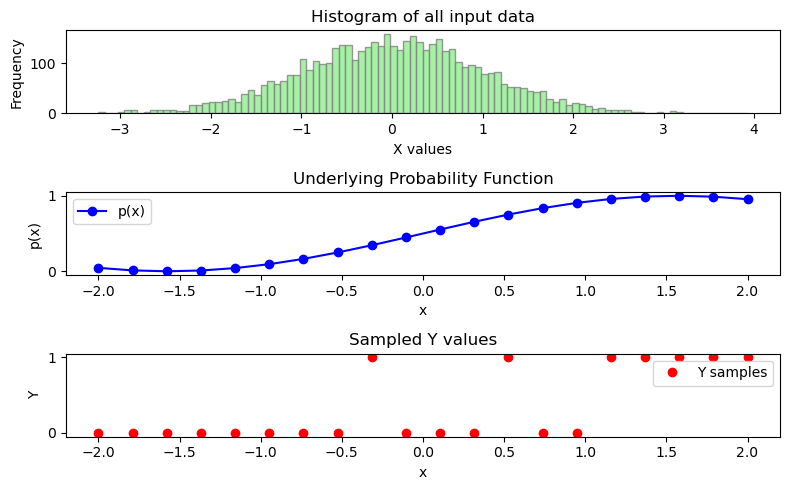

In [ ]:
def plot_generated_data(train_loader, val_loader, test_loader, plot_range=(-2, 2), num_plot_points=20):
    # Collect all X values from the three loaders.
    X_list = []
    for loader in [train_loader, val_loader, test_loader]:
        for inputs, _ in loader:
            X_list.append(inputs)
    # Concatenate along the first dimension and flatten (since each X is of shape [batch, 1])
    X_all = torch.cat(X_list, dim=0).numpy().flatten()
    print("Combined X shape:", X_all.shape)

    # Prepare plotting data for the underlying function:
    plot_points = np.linspace(plot_range[0], plot_range[1], num_plot_points)
    p_plot = 0.5 + 0.5 * np.sin(plot_points)
    # Generate corresponding Y values from Bernoulli (note: this is just one sample per x)
    Y_plot = bernoulli.rvs(p_plot)

    # Plot everything
    plt.figure(figsize=(8, 5))

    # Subplot 1: Histogram of all input data
    plt.subplot(3, 1, 1)
    plt.hist(X_all, bins=100, color='lightgreen', edgecolor='grey', alpha=0.8)
    plt.title("Histogram of all input data")
    plt.xlabel("X values")
    plt.ylabel("Frequency")

    # Subplot 2: Underlying probability function
    plt.subplot(3, 1, 2)
    plt.plot(plot_points, p_plot, marker='o', linestyle='-', color='blue', label='p(x)')
    plt.title("Underlying Probability Function")
    plt.xlabel("x")
    plt.ylabel("p(x)")
    plt.legend()

    # Subplot 3: Sampled Y values vs. x
    plt.subplot(3, 1, 3)
    plt.plot(plot_points, Y_plot, marker='o', linestyle='None', color='red', label='Y samples')
    plt.title("Sampled Y values")
    plt.xlabel("x")
    plt.ylabel("Y")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage (assuming you have already created train_loader, val_loader, and test_loader):
plot_generated_data(train_loader, val_loader, test_loader, plot_range=(-2, 2), num_plot_points=20)


### Load models

In [ ]:
import sys
# locally
#sys.path.append('../src')

# for colab
from google.colab import drive
drive.mount('/content/drive')

# Append your folder's path to sys.path
sys.path.append('/content/drive/MyDrive/Thesis_REMOVE/')

from members import SimpleNN
from deep_ensemble import DeepEnsemble
from calibrator import Calibrator

from plotting import plot_metrics, plot_confusion_matrix

Early stopping triggered at epoch 17.


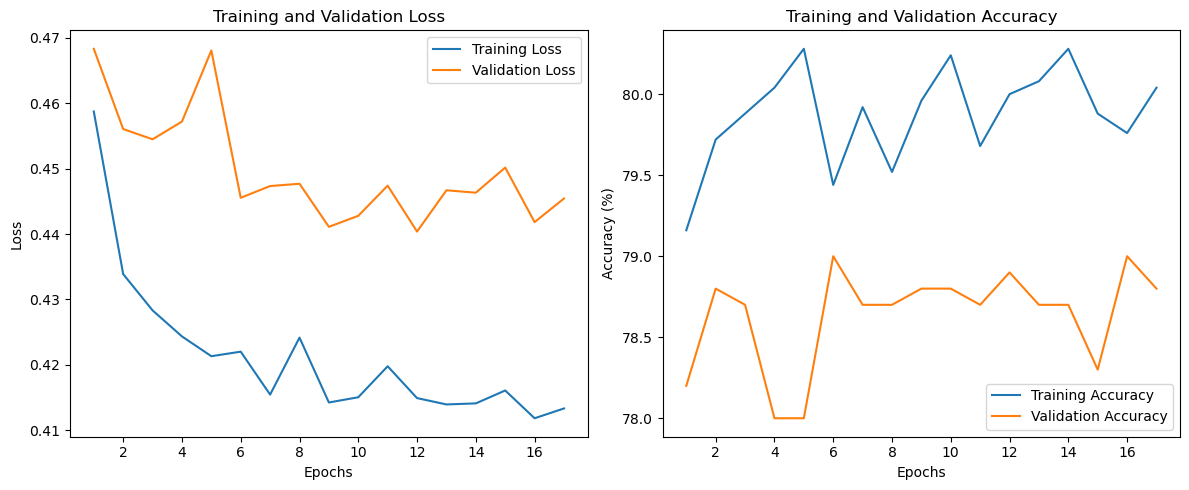

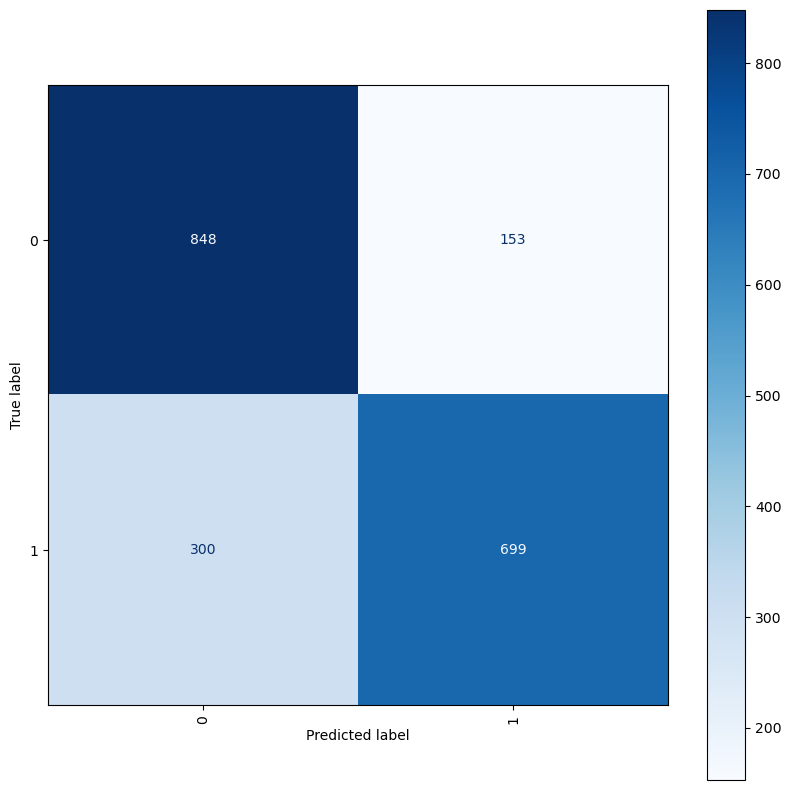

In [ ]:
input_shape = 1
output_shape = 2

lr = 1e-3
criterion = nn.CrossEntropyLoss()
num_epochs = 30
patience = 5
min_delta = 1e-6

snn = SimpleNN(input_shape, output_shape)
optimizer = torch.optim.Adam(snn.parameters(), lr=lr)
train_losses, train_accuracies, val_losses, val_accuracies = snn.train_model(train_loader, val_loader, criterion, optimizer,
                                                                            num_epochs, True,
                                                                             patience, min_delta)

# Plot the training and validation metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, len(val_losses))

# Evluating the model
class_names = [str(i) for i in range(2)]
#plot_confusion_matrix(snn, test_loader, class_names)
plot_confusion_matrix(snn, holdout_loader, class_names)

DeepEnsemble(
  (models): ModuleList(
    (0-4): 5 x SimpleNN(
      (fc1): Linear(in_features=1, out_features=32, bias=True)
      (fc2): Linear(in_features=32, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=128, bias=True)
      (fc4): Linear(in_features=128, out_features=2, bias=True)
    )
  )
)
Early stopping triggered for model 0 at epoch 22.
Early stopping triggered for model 1 at epoch 22.
Early stopping triggered for model 2 at epoch 22.
Early stopping triggered for model 3 at epoch 22.
Early stopping triggered for model 4 at epoch 22.
All models have stopped. Ending training at epoch 22.


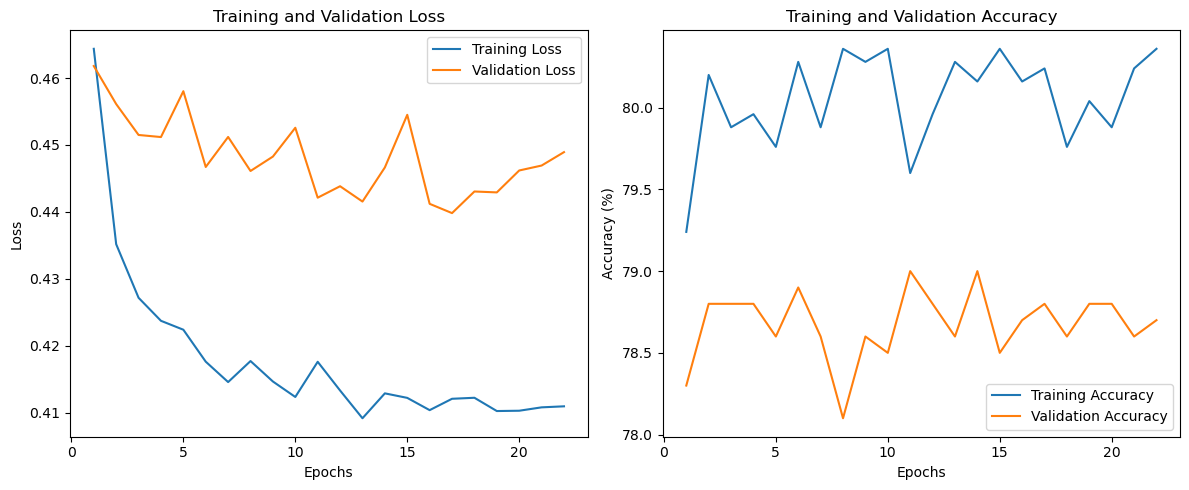

Validation accuracy:  78.7


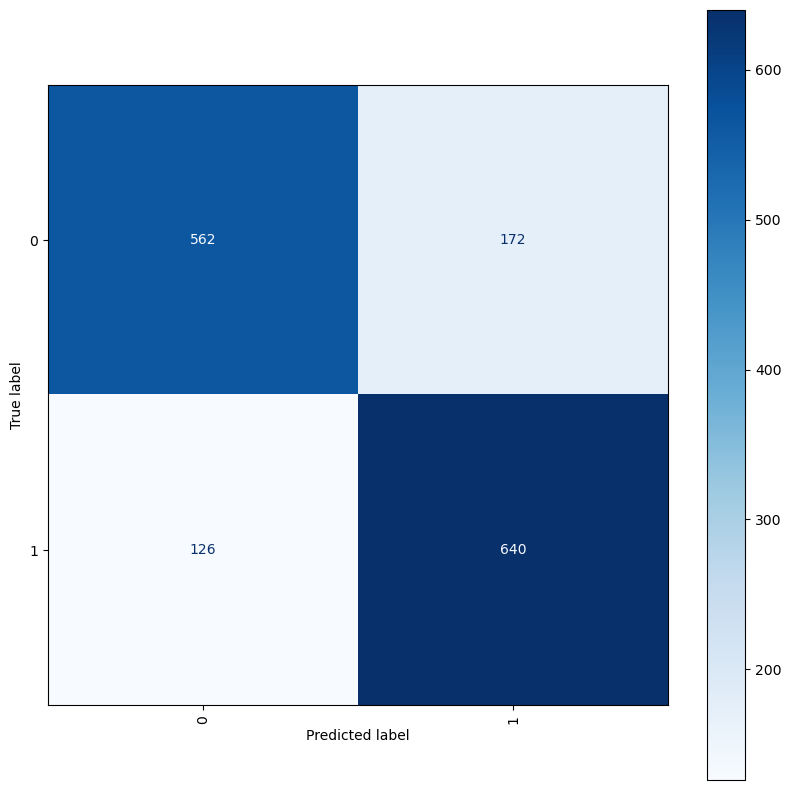

In [ ]:
epsilon = 0.1
weight_decay = 1e-5

#instnatiate the deep ensemble
ensemble_model = DeepEnsemble( num_models=5, model_class=SimpleNN, lr=lr, weight_decay=weight_decay,
                             output_shape = output_shape , input_shape = input_shape  # Passed as keyword argument to SimpleClassifier
                             )
print(ensemble_model)

de_train_results = ensemble_model.train_model(train_loader, val_loader, criterion, num_epochs, epsilon,
                                              adversarial_training=False, early_stopping=True,   # NOTE false
                                              patience=5, min_delta=1e-6)
#plot the results
plot_metrics(de_train_results['train_losses'], de_train_results['val_losses'],
             de_train_results['train_accuracies'],  de_train_results['val_accuracies'], len(de_train_results['train_losses']))
print("Validation accuracy: ", de_train_results['val_accuracies'][-1])
plot_confusion_matrix(ensemble_model, test_loader, class_names=class_names)

# Full pipeline

### Check that grid is right

1. With early stopping
2. Without early stopping

### Early stopping

In [ ]:
num_seeds = 10

# some duplicatese
lr = 1e-3
weight_decay = 5e-4
num_epochs = 50
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.0      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{train_ratio}_{val_ratio}_{test_ratio}_{batch_size}_OOD_with_noise",

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    model_member = SimpleNN(input_shape, output_shape)
    optimizer = torch.optim.Adam(model_member.parameters(), lr=lr, weight_decay=weight_decay)
    _ = model_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping=True,                                                 # NOTE true
                               patience=patience, min_delta=min_delta)

    model_val = model_member.predict(val_loader)
    model_test = model_member.predict(test_loader)
    model_holdout = model_member.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(model_val['nll']),
        "NLL Test": np.mean(model_test['nll']),
        "NLL Holdout": np.mean(model_holdout['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=SimpleNN, lr = lr, weight_decay=weight_decay)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=False,                      # NOTE false
                                  early_stopping=True,                             # NOTE true
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)
    ensemble_holdout = deep_ensemble.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll']),
        "NLL Holdout": np.mean(ensemble_holdout['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 3, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 5, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 1, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_holdout = calibrator.predict(holdout_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"]),
            "NLL Holdout": np.mean(calib_holdout["nll"])
        })



# NOTE naming based of data
df_results_no_AT = pd.DataFrame(results_list)


df_mean = df_results_no_AT.groupby(['Model'])[['NLL Val', 'NLL Test', 'NLL Holdout', 'C1', 'C2', 'Epi Scalar', 'Epsilon' ]].mean()
df_mean = df_mean.sort_values(by='NLL Test', ascending=True)
df_mean

In [ ]:
num_seeds = 10

# some duplicatese
lr = 1e-3
weight_decay = 5e-4
num_epochs = 50
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.1      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{train_ratio}_{val_ratio}_{test_ratio}_{batch_size}_OOD_with_noise",

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    model_member = SimpleNN(input_shape, output_shape)
    optimizer = torch.optim.Adam(model_member.parameters(), lr=lr, weight_decay=weight_decay)
    _ = model_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping=True,                                                 # NOTE true
                               patience=patience, min_delta=min_delta)

    model_val = model_member.predict(val_loader)
    model_test = model_member.predict(test_loader)
    model_holdout = model_member.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(model_val['nll']),
        "NLL Test": np.mean(model_test['nll']),
        "NLL Holdout": np.mean(model_holdout['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=SimpleNN, lr = lr, weight_decay=weight_decay)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=True,                      # NOTE true
                                  early_stopping=True,                             # NOTE true
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)
    ensemble_holdout = deep_ensemble.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll']),
        "NLL Holdout": np.mean(ensemble_holdout['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 3, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 5, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 1, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_holdout = calibrator.predict(holdout_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"]),
            "NLL Holdout": np.mean(calib_holdout["nll"])
        })



# NOTE naming based of data
df_results_AT = pd.DataFrame(results_list)


df_mean = df_results_AT.groupby(['Model'])[['NLL Val', 'NLL Test', 'NLL Holdout', 'C1', 'C2', 'Epi Scalar', 'Epsilon' ]].mean()
df_mean = df_mean.sort_values(by='NLL Test', ascending=True)
df_mean

### No early stopping

#### Set the right num_epochs

In [ ]:
num_seeds = 10

# some duplicatese
lr = 1e-3
weight_decay = 5e-4
num_epochs = 50
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.0      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{train_ratio}_{val_ratio}_{test_ratio}_{batch_size}_OOD_with_noise",

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    model_member = SimpleNN(input_shape, output_shape)
    optimizer = torch.optim.Adam(model_member.parameters(), lr=lr, weight_decay=weight_decay)
    _ = model_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping=False,                                                 # NOTE False
                               patience=patience, min_delta=min_delta)

    model_val = model_member.predict(val_loader)
    model_test = model_member.predict(test_loader)
    model_holdout = model_member.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(model_val['nll']),
        "NLL Test": np.mean(model_test['nll']),
        "NLL Holdout": np.mean(model_holdout['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=SimpleNN, lr = lr, weight_decay=weight_decay)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=False,                      # NOTE false
                                  early_stopping=False,                             # NOTE False
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)
    ensemble_holdout = deep_ensemble.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll']),
        "NLL Holdout": np.mean(ensemble_holdout['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 3, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 5, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 1, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_holdout = calibrator.predict(holdout_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"]),
            "NLL Holdout": np.mean(calib_holdout["nll"])
        })



# NOTE naming based of data
df_results_no_AT_noES = pd.DataFrame(results_list)


df_mean = df_results_no_AT_noES.groupby(['Model'])[['NLL Val', 'NLL Test', 'NLL Holdout', 'C1', 'C2', 'Epi Scalar', 'Epsilon' ]].mean()
df_mean = df_mean.sort_values(by='NLL Test', ascending=True)
df_mean

In [ ]:
num_seeds = 10

# some duplicatese
lr = 1e-3
weight_decay = 5e-4
num_epochs = 50
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.1      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{train_ratio}_{val_ratio}_{test_ratio}_{batch_size}_OOD_with_noise",

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    model_member = SimpleNN(input_shape, output_shape)
    optimizer = torch.optim.Adam(model_member.parameters(), lr=lr, weight_decay=weight_decay)
    _ = model_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping=False,                                                 # NOTE true
                               patience=patience, min_delta=min_delta)

    model_val = model_member.predict(val_loader)
    model_test = model_member.predict(test_loader)
    model_holdout = model_member.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(model_val['nll']),
        "NLL Test": np.mean(model_test['nll']),
        "NLL Holdout": np.mean(model_holdout['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=SimpleNN, lr = lr, weight_decay=weight_decay)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=True,                      # NOTE true
                                  early_stopping=False,                             # NOTE False
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)
    ensemble_holdout = deep_ensemble.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll']),
        "NLL Holdout": np.mean(ensemble_holdout['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 3, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 5, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 1, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_holdout = calibrator.predict(holdout_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"]),
            "NLL Holdout": np.mean(calib_holdout["nll"])
        })



# NOTE naming based of data
df_results_AT_noES = pd.DataFrame(results_list)


df_mean = df_results_AT_noES.groupby(['Model'])[['NLL Val', 'NLL Test', 'NLL Holdout', 'C1', 'C2', 'Epi Scalar', 'Epsilon' ]].mean()
df_mean = df_mean.sort_values(by='NLL Test', ascending=True)
df_mean